# 2D Image Regression Demo
### Learned Initializations for Optimizing Coordinate-Based Neural Representations
[Project Website](https://www.matthewtancik.com/learnit)

[arXiv](https://arxiv.org/abs/2012.02189)

In [ ]:
!pip install -q optax
!pip install -q git+https://github.com/deepmind/dm-haiku

     |████████████████████████████████| 140 kB 32.7 MB/s 
     |████████████████████████████████| 72 kB 724 kB/s 


In [ ]:
pip install livelossplot

     |████████████████████████████████| 793 kB 35.1 MB/s 
     |████████████████████████████████| 381 kB 55.1 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.33.0 which is incompatible.


In [ ]:
pip install optax

In [ ]:
pip install phantominator

     |████████████████████████████████| 60 kB 9.7 MB/s 


In [ ]:
from functools import partial
import jax
from jax import random, grad, jit, vmap, flatten_util, nn
#from jax.experimental import optix
from jax.config import config
import optax
import jax.numpy as np

import haiku as hk

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import cv2
import imageio
from jax.scipy import ndimage

from phantominator import shepp_logan, ct_shepp_logan, ct_modified_shepp_logan_params_2d

import pickle

In [ ]:
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


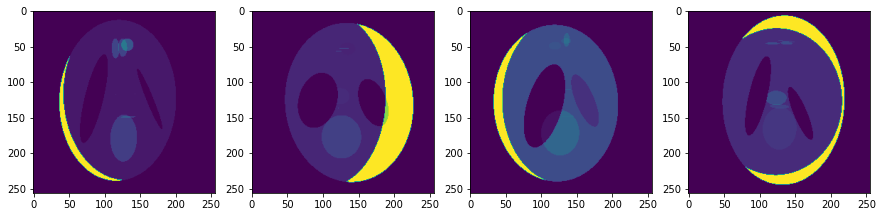

In [ ]:
DATA_DIR = '/content/drive/MyDrive/ct_256.pkl' ## Update

with open(DATA_DIR, 'rb') as file:
    dataset = pickle.load(file)
    
x1 = np.linspace(0, 1, dataset['data_test'][0].shape[0]+1)[:-1] # use full image resolution 
x_train = np.stack(np.meshgrid(x1,x1), axis=-1)
x_test = x_train

plt.figure(figsize=(15,8))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(dataset['data_test'][i,:,:])
plt.show()

In [ ]:
class Model(hk.Module):
    def __init__(self):
        super().__init__()
        self.rff = random.normal(jax.random.PRNGKey(0), shape=(2,256)) * 30
        self.width = 256
        self.depth = 5        
        
    def __call__(self, coords):
        sh = coords.shape
        coords = np.reshape(coords, [-1,2])
        
        x = np.concatenate([np.sin(coords @ self.rff), np.cos(coords @ self.rff)], axis=-1)

        for _ in range(self.depth-1):
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            
        out = hk.Linear(output_size=1)(x)
        out = jax.nn.sigmoid(out)
        out = np.reshape(out, list(sh[:-1]))
        return out

In [ ]:
@jit
def ct_project(img, theta):
    y, x = np.meshgrid(np.arange(int(img.shape[0]), dtype=np.float32)/int(img.shape[0]) - 0.5, np.arange(int(img.shape[1]), dtype=np.float32)/int(img.shape[1]) - 0.5, indexing='ij')
    x_rot = x*np.cos(theta) - y*np.sin(theta)
    y_rot = x*np.sin(theta) + y*np.cos(theta)
    x_rot = (x_rot + 0.5)*img.shape[1]
    y_rot = (y_rot + 0.5)*img.shape[0]
    sample_coords = np.stack([y_rot, x_rot], axis=0)
    resampled = ndimage.map_coordinates(img, sample_coords, 0).reshape(img.shape)
    return resampled.mean(axis=0)[:,None,...]

ct_project_batch = vmap(ct_project, (None, 0), 0)
ct_project_double_batch = vmap(ct_project_batch, (0, 0), 0)

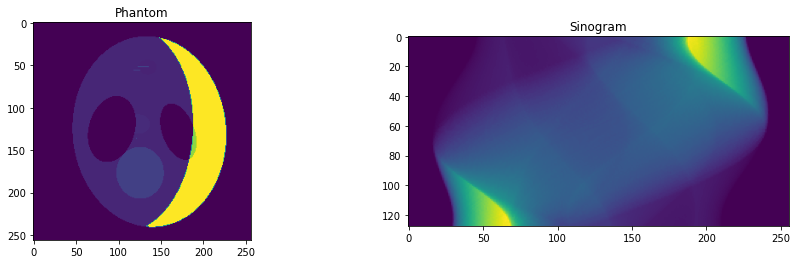

In [ ]:
thetas = np.linspace(0,np.pi, 128)
test_img = dataset['data_test'][1]
projections = ct_project_batch(test_img, thetas)

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('Phantom')
plt.subplot(1,2,2)
plt.imshow(projections[:,:,0])
plt.title('Sinogram')
plt.show()

In [ ]:
# Rerun to reset plots
plt_groups = {'Train PSNR':[], 'Test PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


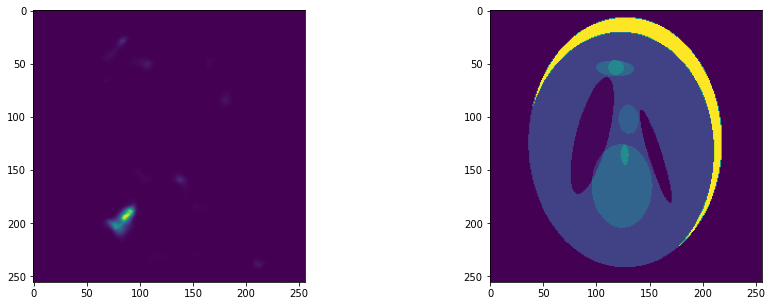

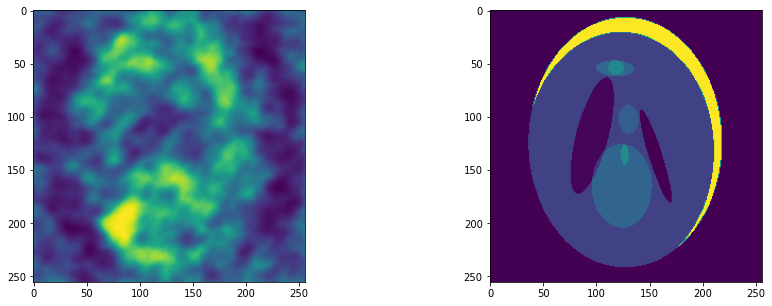

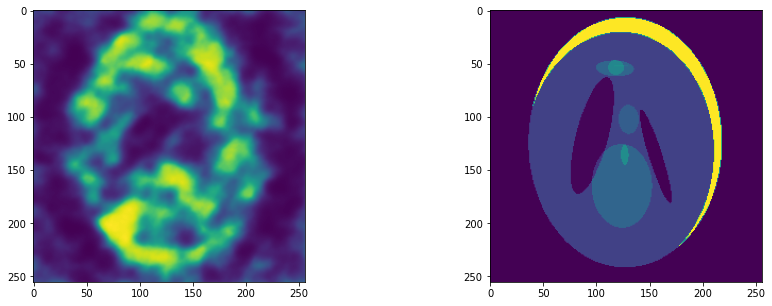

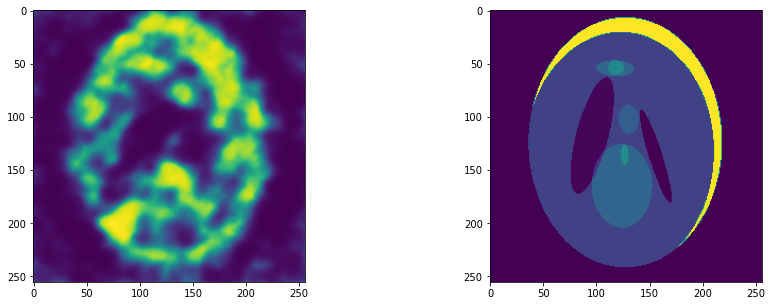

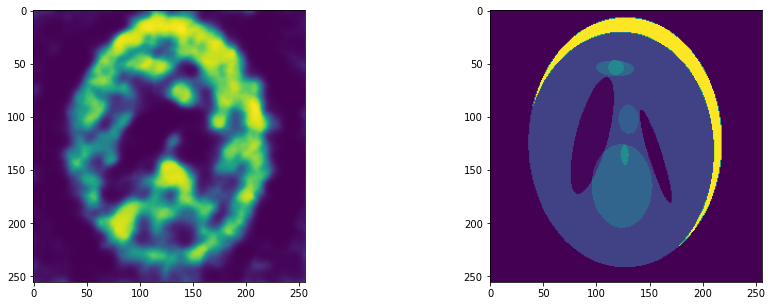

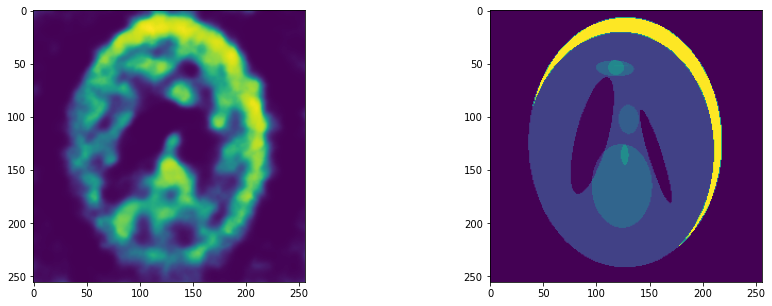

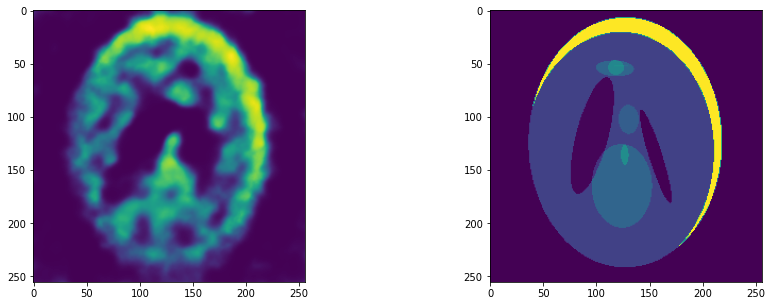

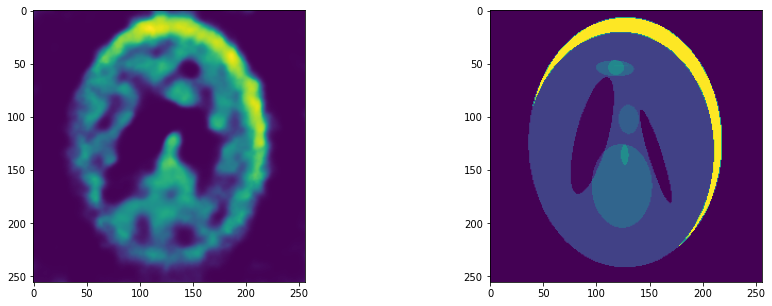

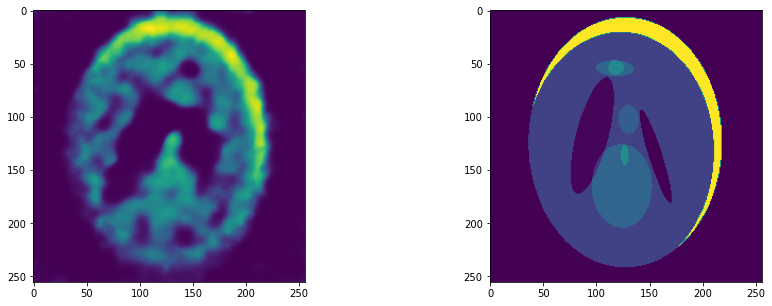

In [ ]:
#CHECKPOINT_DIR = 'checkpoint/ct_checkpoints/' # Choose dir to save checkpoints

max_iters = 1000
test_steps = 10

batch_size = 1
num_projections = 20
num_test_projections = 10

inner_update_steps = 12
inner_lr = 10 #5e-3
lr = 5e-5

exp_name = f'ilr_{inner_lr}_olr_{lr}_ius_{inner_update_steps}_bs_{batch_size}'

test_thetas = np.linspace(0, np.pi, num_test_projections, endpoint=False)

coords = x_train

key = hk.PRNGSequence(42)
model = hk.without_apply_rng(hk.transform(lambda x: Model()(x)))
params = model.init(next(key), np.ones((1,2)))

opt = optax.adam(lr)#, b1=.5, b2=.9)
opt_state = opt.init(params)

opt_inner = optax.sgd(inner_lr)#, b1=.5, b2=.9)
# opt_inner = optix.adam(inner_lr)#, b1=.5, b2=.9)

mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

time_stamps = []
start_time = time.time()

@partial(jit, static_argnums=[4])
def model_step(image_proj, coords, thetas, params, opt, opt_state):
    def loss_latent(params):
        g = model.apply(params, coords)
        g_proj = ct_project_batch(g, thetas)
        return mse_fn(g_proj, image_proj)

    loss, grad = jax.value_and_grad(loss_latent)(params)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

@partial(jit, static_argnums=[5])
def update_network_weights(rng, image_proj, coords, thetas, params, update_steps):
    opt_inner_state = opt_inner.init(params)
    for _ in range(update_steps):
        params, opt_inner_state, loss = model_step(image_proj, coords, thetas, params, opt_inner, opt_inner_state)
    return rng, params, loss

update_network_weights_batch = vmap(update_network_weights, in_axes=[0, 0, None, 0, None, None])

@jit
def update_model(rng, params, opt_state, image, coords, thetas):
    image_proj = ct_project_double_batch(image, thetas)
    rng = random.split(rng, batch_size)
    rng, new_params, loss = update_network_weights_batch(rng, image_proj, coords, thetas, params, inner_update_steps)
    rng, loss = rng[0], np.mean(loss)
    new_params = jax.tree_map(lambda x: np.mean(x, axis=0), new_params)
    def calc_grad(params, new_params):
        return params - new_params

    model_grad = jax.tree_multimap(calc_grad, params, new_params)

    updates, opt_state = opt.update(model_grad, opt_state)
    params = optax.apply_updates(params, updates)
    return rng, params, opt_state, loss

plt_groups['Train PSNR'].append(exp_name+f'_train')
plt_groups['Test PSNR'].append(exp_name+f'_test')

train_psnrs = []
step = 0
rng = random.PRNGKey(0)
rng_test = random.PRNGKey(42)

for step in tqdm(range(max_iters)):
    rng, rng_input = random.split(rng)
    train_idx = random.randint(rng_input, (batch_size,), 0, dataset['data_train'].shape[0])
    train_img = dataset['data_train'][train_idx]
    if batch_size == 1:
        train_img = train_img[None,...]
    
    rng, rng_input = random.split(rng)
    thetas = random.uniform(rng_input, (batch_size, num_projections), minval=0, maxval=np.pi)
    
    rng, params, opt_state, loss = update_model(rng, params, opt_state, train_img, coords, thetas)
    train_psnrs.append(-10 * np.log10(loss))

    if step % 100 == 0:
        #plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnrs = []
    if step % 100 == 0 and step != 0:
        test_psnrs = []
        for i in range(5):
            test_img = dataset['data_test'][i]
            test_img_proj = ct_project_batch(test_img, test_thetas)
            _, params_test, loss = update_network_weights(rng_test, test_img_proj, coords, test_thetas, params, test_steps)
            img = model.apply(params_test, coords)

            test_psnrs.append(psnr_fn(img, test_img))
        #plotlosses_model.update({exp_name+'_test':np.mean(np.array(test_psnrs))}, current_step=step)
        #plotlosses_model.send()
        time_stamps.append(time.time()-start_time)
        plt.figure(figsize=(15,5))        
        plt.subplot(1,2, 1)
        plt.imshow(img)
        plt.subplot(1,2, 2)
        plt.imshow(test_img)
        plt.show()
    

In [ ]:
mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))
RES = 256
@partial(jit, static_argnums=[0,5])
def test_model_step(model, image_proj, coords, thetas, params, opt, opt_state):
    def loss_fn(params):
        g = model.apply(params, coords)
        g_proj = ct_project_batch(g, thetas)
        return mse_fn(g_proj, image_proj), g

    (loss, img), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, img

def train_model(image, lr, steps, num_views, adam=True, params=None):
    rng = random.PRNGKey(0)
    x1 = np.linspace(0, 1, RES+1)[:-1]
    coords = np.stack(np.meshgrid(x1,x1), axis=-1)
    
    thetas = np.linspace(0,np.pi, num_views, endpoint=False)
    image_proj = ct_project_batch(image, thetas)

    model = hk.without_apply_rng(hk.transform(lambda x: Model()(x)))
    if params is None:
        params = model.init(rng, coords)
        
    if adam:
        opt = optax.adam(lr)
    else:
        opt = optax.sgd(lr)
    opt_state = opt.init(params)
    
    train_psnrs = []
    test_psnrs = []
    #the below is the test
    for i in range(steps):
        params, opt_state, loss, img = test_model_step(model, image_proj, coords, thetas, params, opt, opt_state)
        train_psnrs.append(-10 * np.log10(loss))
        meta_psnr = psnr_fn(img, image)
        test_psnrs.append(meta_psnr)

        

    return train_psnrs, test_psnrs, img, params

In [ ]:
print(test_psnrs)

[DeviceArray(19.1263, dtype=float32), DeviceArray(19.035454, dtype=float32), DeviceArray(18.42574, dtype=float32), DeviceArray(17.970499, dtype=float32), DeviceArray(18.051893, dtype=float32)]


In [ ]:
#meta
mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))
RES = 256
@partial(jit, static_argnums=[0,5])
def test_model_step1(model, image_proj, coords, thetas, params, opt, opt_state):
    def loss_fn(params):
        g = model.apply(params, coords)
        g_proj = ct_project_batch(g, thetas)
        return mse_fn(g_proj, image_proj), g

    (loss, img), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, img


def train_model1(image, lr, steps, num_views, adam=True, params=None):
    meta_psnrs = []
    meta_time_stamps = []
    meta_time_stamps_not_count_train_time = []
    meta_train_time = time_stamps[-1]
    meta_start_time = time.time()
    meta_steps = []


    rng = random.PRNGKey(0)
    x1 = np.linspace(0, 1, RES+1)[:-1]
    coords = np.stack(np.meshgrid(x1,x1), axis=-1)
    
    thetas = np.linspace(0,np.pi, num_views, endpoint=False)
    image_proj = ct_project_batch(image, thetas)

    model = hk.without_apply_rng(hk.transform(lambda x: Model()(x)))
    if params is None:
        params = model.init(rng, coords)
        
    if adam:
        opt = optax.adam(lr)
    else:
        opt = optax.sgd(lr)
    opt_state = opt.init(params)
    
    train_psnrs = []
    test_psnrs = []
    #the below is the test
    for i in range(steps):
        params, opt_state, loss, img = test_model_step1(model, image_proj, coords, thetas, params, opt, opt_state)
        train_psnrs.append(-10 * np.log10(loss))
        meta_psnr = psnr_fn(img, image)
        #test_psnrs.append(meta_psnr)
        meta_psnrs.append(meta_psnr)
        meta_time_stamps.append(time.time()+meta_train_time-meta_start_time)
        meta_time_stamps_not_count_train_time.append(time.time()-meta_start_time)
        meta_steps.append(i)

        #print(meta_psnr)
        #plt.figure(figsize=(15,5))
        #plt.subplot(1,2,1)
        #plt.imshow((np.clip(img, 0, 1)*255).astype(np.uint8))
        #plt.subplot(1,2,2)
        #plt.imshow(image)
        #plt.show()

    return meta_psnrs,meta_time_stamps,meta_time_stamps_not_count_train_time,meta_steps, train_psnrs, test_psnrs, img, params

In [ ]:
#meta train one picture
num_views = 8
lr = 10
steps = 500
adam = False

num_examples = 1
meta_psnrs = []
meta_time_stamps = []
meta_time_stamps_not_count_train_time = []
meta_steps = []
for image in dataset['data_test'][:num_examples]:
    meta_psnrs,meta_time_stamps,meta_time_stamps_not_count_train_time,meta_steps,train_psnrs, test_psnrs, rec_img, _ = train_model1(image, lr, steps, num_views, adam, params)
    rec_img = (np.clip(rec_img, 0, 1)*255).astype(np.uint8)
    
    #plt.figure(figsize=(15,4))
    #plt.imshow(image)
    #plt.title('Target')
    #plt.subplot(1,2,2)
    #plt.imshow(rec_img)
    #plt.title(f'Reconstruction ({num_views} views)')
    #plt.show()

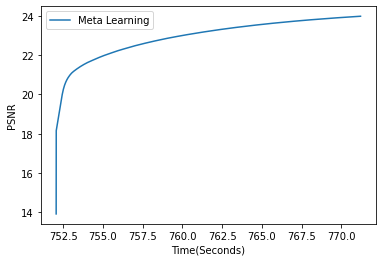

In [ ]:
#table1(1)
plt.plot(meta_time_stamps,meta_psnrs,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.ylabel('PSNR')
plt.xlabel('Time(Seconds)')
plt.show()

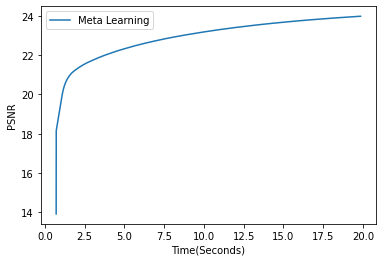

In [ ]:
#table1(2)
plt.plot(meta_time_stamps_not_count_train_time,meta_psnrs,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.ylabel('PSNR')
plt.xlabel('Time(Seconds)')
plt.show()

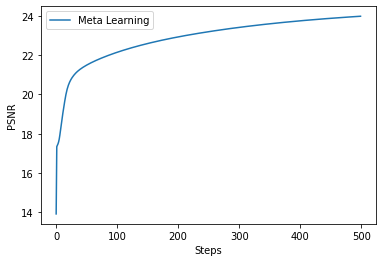

In [ ]:
#table1(3)
plt.plot(meta_steps,meta_psnrs,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.ylabel('PSNR')
plt.xlabel('Steps')
plt.show()

In [ ]:
#random
mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))
RES = 256
@partial(jit, static_argnums=[0,5])
def test_model_step2(model, image_proj, coords, thetas, params, opt, opt_state):
    def loss_fn(params):
        g = model.apply(params, coords)
        g_proj = ct_project_batch(g, thetas)
        return mse_fn(g_proj, image_proj), g

    (loss, img), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, img

def train_model2(image, lr, steps, num_views, adam=True, params=None):
    random_psnrs = []
    random_time_stamps = []
    random_start_time = time.time()
    random_steps = []

    rng = random.PRNGKey(0)
    x1 = np.linspace(0, 1, RES+1)[:-1]
    coords = np.stack(np.meshgrid(x1,x1), axis=-1)
    
    thetas = np.linspace(0,np.pi, num_views, endpoint=False)
    image_proj = ct_project_batch(image, thetas)

    model = hk.without_apply_rng(hk.transform(lambda x: Model()(x)))
    if params is None:
        params = model.init(rng, coords)
        
    if adam:
        opt = optax.adam(lr)
    else:
        opt = optax.sgd(lr)
    opt_state = opt.init(params)
    
    train_psnrs = []
    test_psnrs = []
    #the below is the test
    for i in range(steps):
        params, opt_state, loss, img = test_model_step2(model, image_proj, coords, thetas, params, opt, opt_state)
        train_psnrs.append(-10 * np.log10(loss))
        meta_psnr = psnr_fn(img, image)
        #test_psnrs.append(meta_psnr)
        random_psnrs.append(meta_psnr)
        random_time_stamps.append(time.time()-random_start_time)      
        random_steps.append(i)

        #print(meta_psnr)
        #plt.figure(figsize=(15,5))
        #plt.subplot(1,2,1)
        #plt.imshow((np.clip(img, 0, 1)*255).astype(np.uint8))
        #plt.subplot(1,2,2)
        #plt.imshow(image)
        #plt.show()

        

    return random_psnrs,random_time_stamps,random_steps,train_psnrs, test_psnrs, img, params

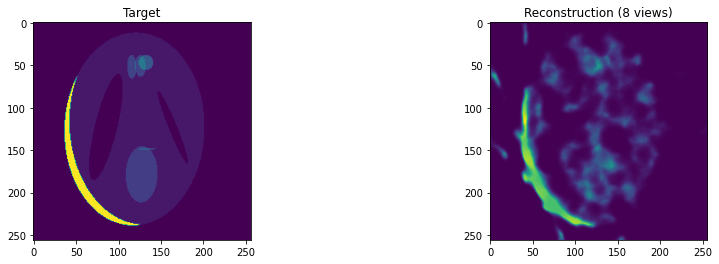

In [ ]:
#random initial for one picture
random_psnrs = []
random_time_stamps = []
random_steps = []
num_views = 8
lr = 5e-4
steps = 500
adam = True
key = hk.PRNGSequence(42)
model = hk.without_apply_rng(hk.transform(lambda x: Model()(x)))
random_params = model.init(next(key), np.ones((1,2)))
num_examples = 1

for image in dataset['data_test'][:num_examples]:
    random_psnrs,random_time_stamps,random_steps,train_psnrs, test_psnrs, rec_img, _ = train_model2(image, lr, steps, num_views, adam, random_params)
    rec_img = (np.clip(rec_img, 0, 1)*255).astype(np.uint8)
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Target')
    plt.subplot(1,2,2)
    plt.imshow(rec_img)
    plt.title(f'Reconstruction ({num_views} views)')
    plt.show()

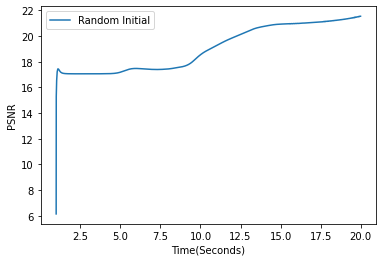

In [ ]:
#table1(4)
plt.plot(random_time_stamps,random_psnrs,label='Random Initial')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.ylabel('PSNR')
plt.xlabel('Time(Seconds)')
plt.show()

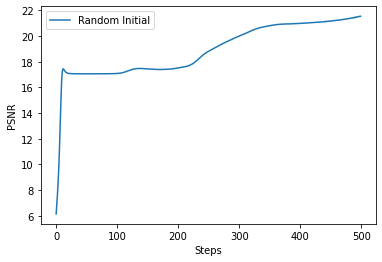

In [ ]:
#table1(5)
plt.plot(random_steps,random_psnrs,label='Random Initial')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.ylabel('PSNR')
plt.xlabel('Steps')
plt.show()

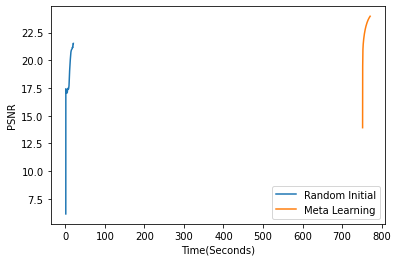

In [ ]:
#table1(6)
plt.plot(random_time_stamps,random_psnrs,label='Random Initial')
plt.plot(meta_time_stamps,meta_psnrs,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.ylabel('PSNR')
plt.xlabel('Time(Seconds)')
plt.show()

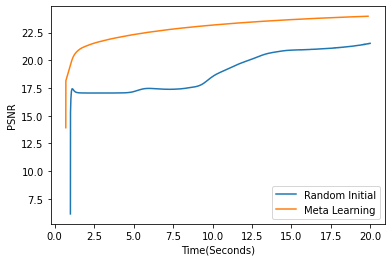

In [ ]:
#table1(7)
plt.plot(random_time_stamps,random_psnrs,label='Random Initial')
plt.plot(meta_time_stamps_not_count_train_time,meta_psnrs,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.ylabel('PSNR')
plt.xlabel('Time(Seconds)')
plt.show()

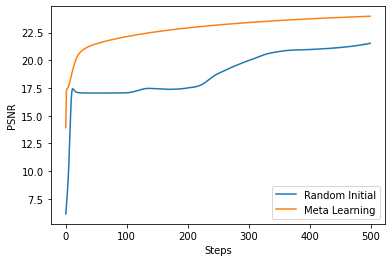

In [ ]:
#table1(8)
plt.plot(random_steps,random_psnrs,label='Random Initial')
plt.plot(meta_steps,meta_psnrs,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.ylabel('PSNR')
plt.xlabel('Steps')
plt.show()

In [ ]:
#table2

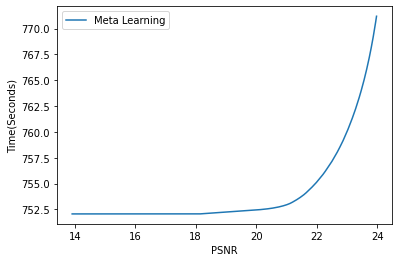

In [ ]:
#table2(1)
#plt.plot(meta_time_stamps,meta_psnrs,label='Meta Learning')
plt.plot(meta_psnrs,meta_time_stamps,label="Meta Learning")
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.ylabel('Time(Seconds)')
plt.xlabel('PSNR')
plt.show()

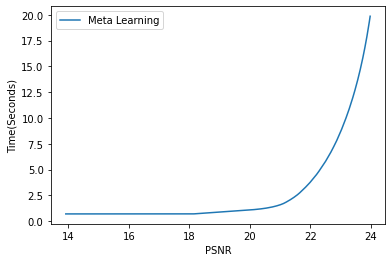

In [ ]:
#table2(2)
#plt.plot(meta_time_stamps_not_count_train_time,meta_psnrs,label='Meta Learning')
plt.plot(meta_psnrs,meta_time_stamps_not_count_train_time,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.xlabel('PSNR')
plt.ylabel('Time(Seconds)')
plt.show()

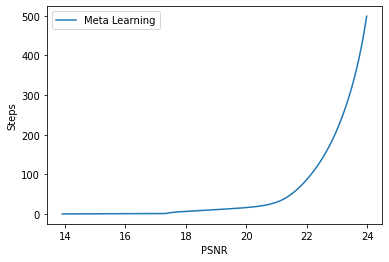

In [ ]:
#table2(3)
#plt.plot(meta_steps,meta_psnrs,label='Meta Learning')
plt.plot(meta_psnrs,meta_steps,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.xlabel('PSNR')
plt.ylabel('Steps')
plt.show()

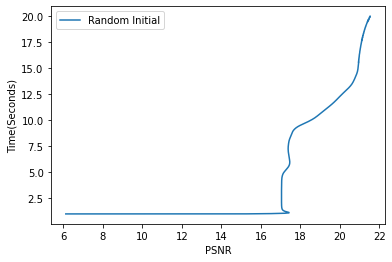

In [ ]:
#table2(4)
#plt.plot(random_time_stamps,random_psnrs,label='Random Initial')
plt.plot(random_psnrs,random_time_stamps,label='Random Initial')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.xlabel('PSNR')
plt.ylabel('Time(Seconds)')
plt.show()

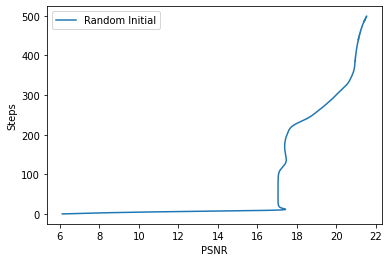

In [ ]:
#table2(5)
#plt.plot(random_steps,random_psnrs,label='Random Initial')
plt.plot(random_psnrs,random_steps,label='Random Initial')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.xlabel('PSNR')
plt.ylabel('Steps')
plt.show()

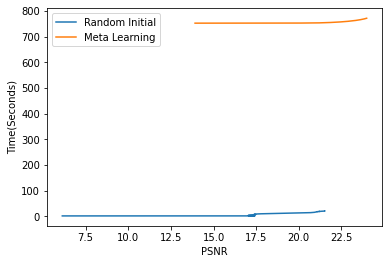

In [ ]:
#table2(6)
#plt.plot(random_time_stamps,random_psnrs,label='Random Initial')
plt.plot(random_psnrs,random_time_stamps,label='Random Initial')
#plt.plot(meta_time_stamps,meta_psnrs,label='Meta Learning')
plt.plot(meta_psnrs,meta_time_stamps,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.xlabel('PSNR')
plt.ylabel('Time(Seconds)')
plt.show()

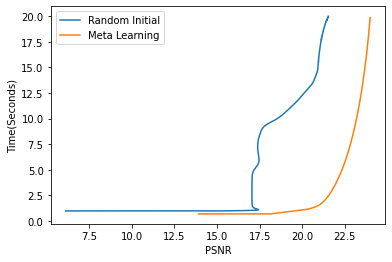

In [ ]:
#table2(7)
#plt.plot(random_time_stamps,random_psnrs,label='Random Initial')
plt.plot(random_psnrs,random_time_stamps,label='Random Initial')
#plt.plot(meta_time_stamps_not_count_train_time,meta_psnrs,label='Meta Learning')
plt.plot(meta_psnrs,meta_time_stamps_not_count_train_time,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.xlabel('PSNR')
plt.ylabel('Time(Seconds)')
plt.show()

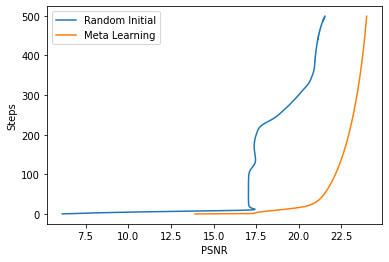

In [ ]:
#table2(8)
#plt.plot(random_steps,random_psnrs,label='Random Initial')
plt.plot(random_psnrs,random_steps,label='Random Initial')
#plt.plot(meta_steps,meta_psnrs,label='Meta Learning')
plt.plot(meta_psnrs,meta_steps,label='Meta Learning')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.xlabel('PSNR')
plt.ylabel('Steps')
plt.show()

In [ ]:
#100 images reach 20 psnr score(meta)
#meta
mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))
RES = 256
@partial(jit, static_argnums=[0,5])
def test_model_step3(model, image_proj, coords, thetas, params, opt, opt_state):
    def loss_fn(params):
        g = model.apply(params, coords)
        g_proj = ct_project_batch(g, thetas)
        return mse_fn(g_proj, image_proj), g

    (loss, img), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, img

#starter = 0
def train_model3(image, lr, steps, num_views, adam=True, params=None):
    
    metatest30ImagesTime = []

    meta30steps = []
    metatest30ImagesStartTime = time.time()
    metatest30Images = []
    startTime = time.time()


    rng = random.PRNGKey(0)
    x1 = np.linspace(0, 1, RES+1)[:-1]
    coords = np.stack(np.meshgrid(x1,x1), axis=-1)
    
    thetas = np.linspace(0,np.pi, num_views, endpoint=False)
    image_proj = ct_project_batch(image, thetas)

    model = hk.without_apply_rng(hk.transform(lambda x: Model()(x)))
    if params is None:
        params = model.init(rng, coords)
        
    if adam:
        opt = optax.adam(lr)
    else:
        opt = optax.sgd(lr)
    opt_state = opt.init(params)
    
    train_psnrs = []
    test_psnrs = []
    
    #the below is the test
    meta30stepsR = steps
    for i in range(steps):
        params, opt_state, loss, img = test_model_step3(model, image_proj, coords, thetas, params, opt, opt_state)
        train_psnrs.append(-10 * np.log10(loss))
        meta_psnr = psnr_fn(img, image)
        metatest30ImagesTimeR =time.time()-metatest30ImagesStartTime
        if meta_psnr>=19:
          metatest30ImagesTimeR =time.time()-metatest30ImagesStartTime
          #metatest30Images.append(starter)
          #meta30steps.append(i)
          meta30stepsR = i
          print(meta_psnr)
          break


        #test_psnrs.append(meta_psnr)
        
        
       


    return metatest30ImagesTimeR,meta30stepsR,train_psnrs, test_psnrs, img, params

19.051998


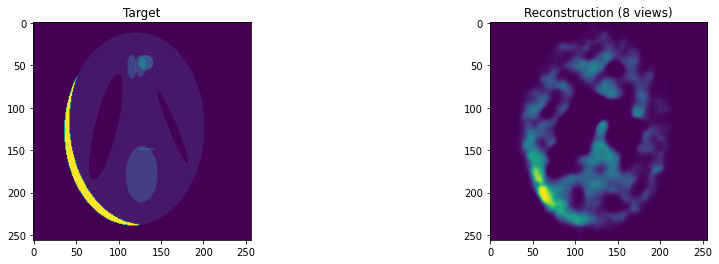

19.145914


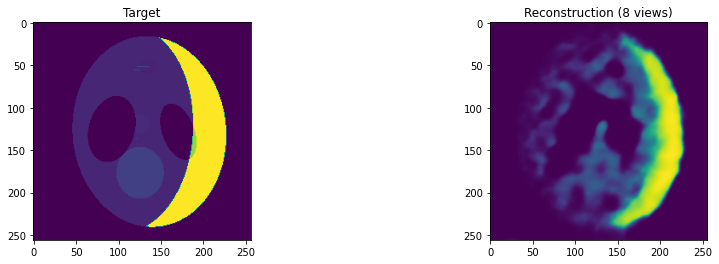

19.017817


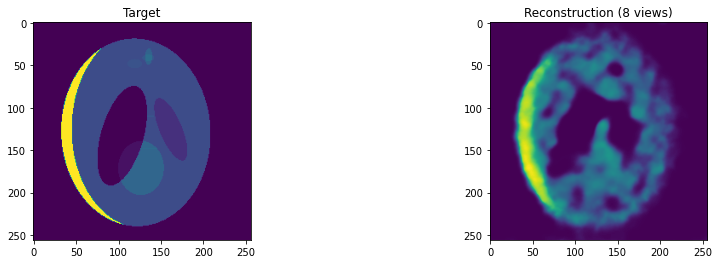

19.0662


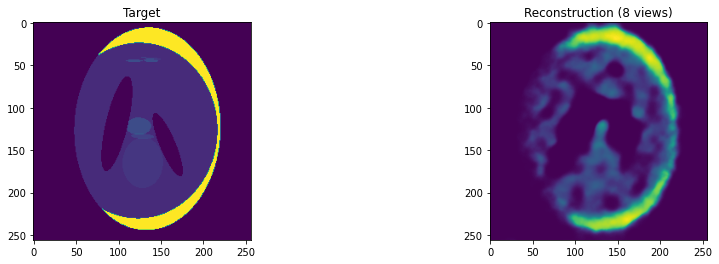

19.019865


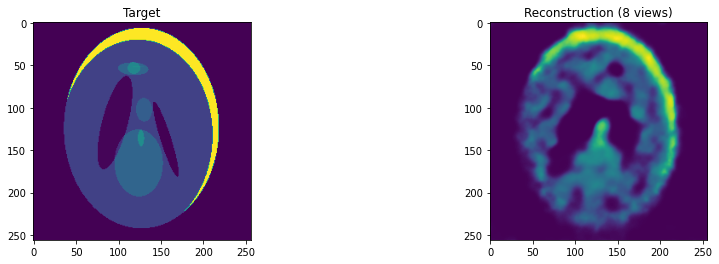

19.109463


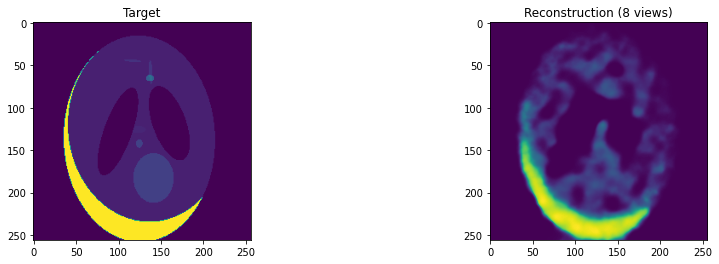

19.001778


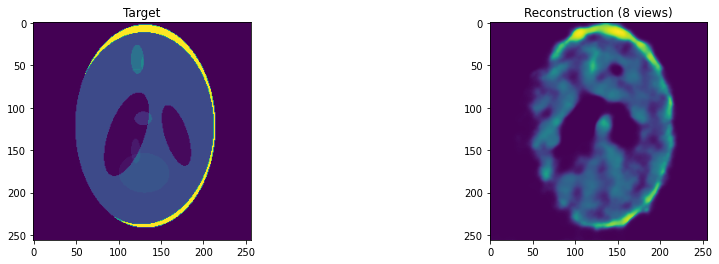

19.018593


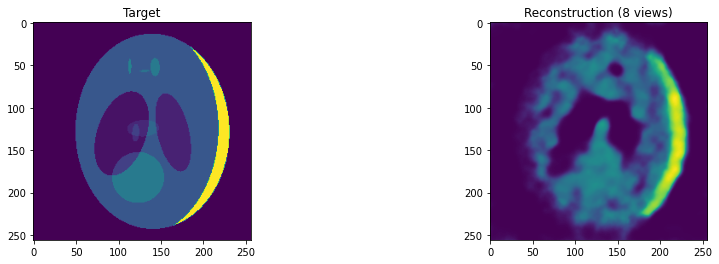

19.005747


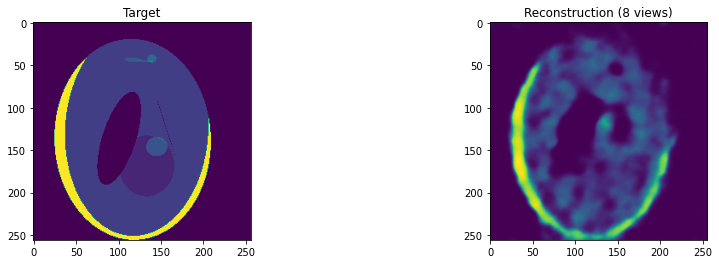

19.012861


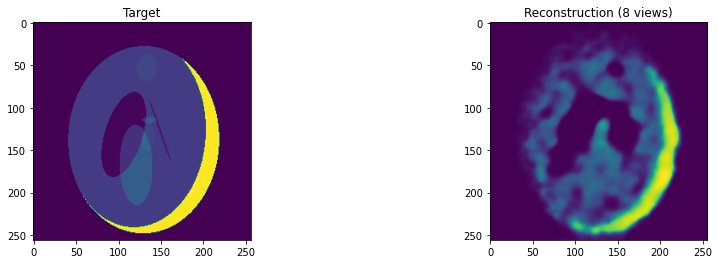

19.006456


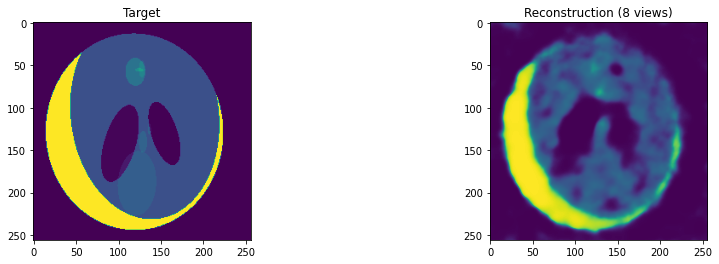

19.028093


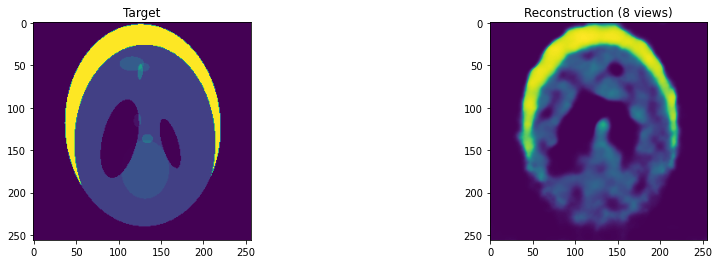

19.031849


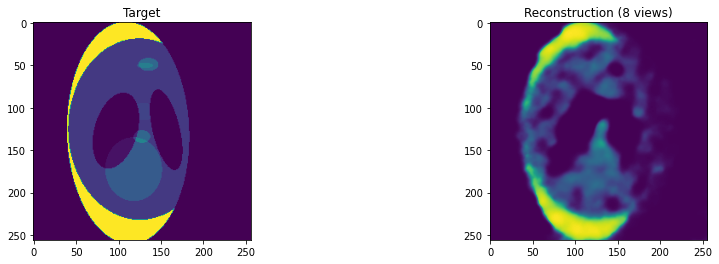

19.006008


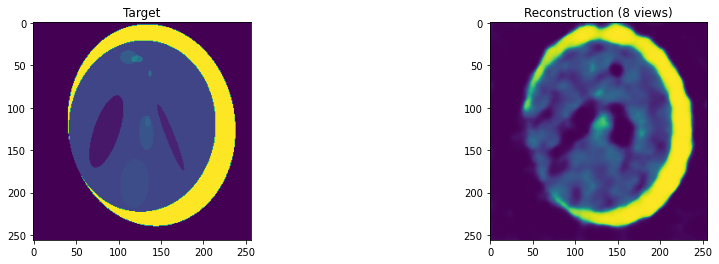

19.004118


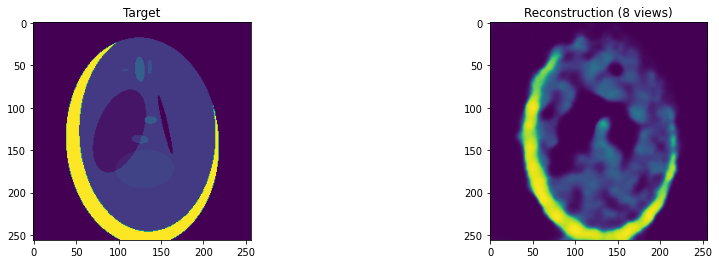

21.345411


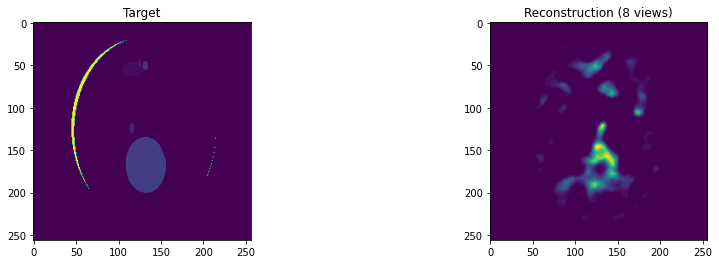

19.008213


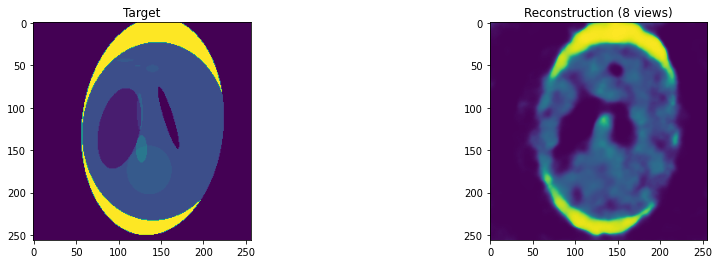

19.117762


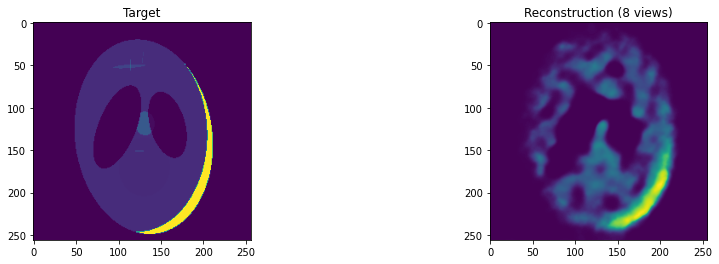

19.03043


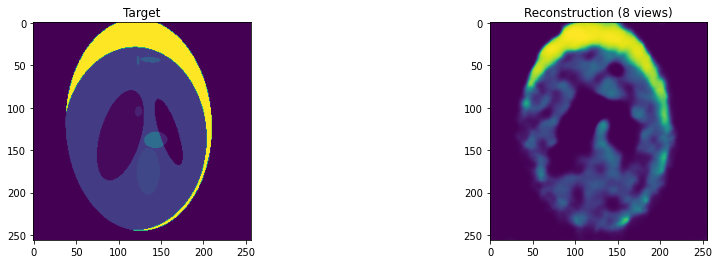

19.009348


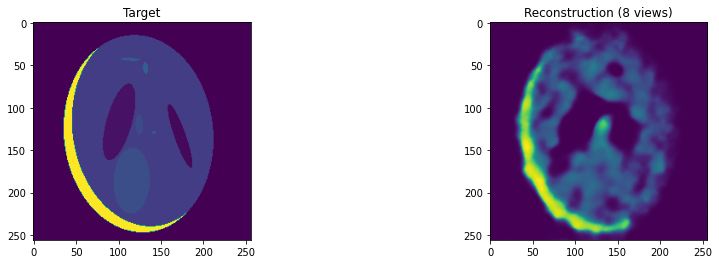

19.003489


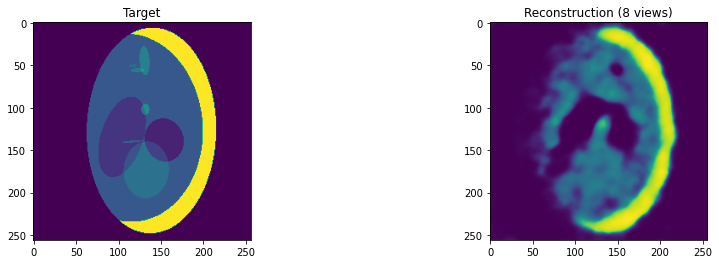

19.004667


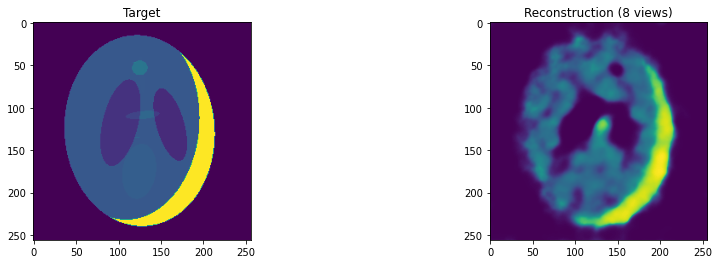

19.004692


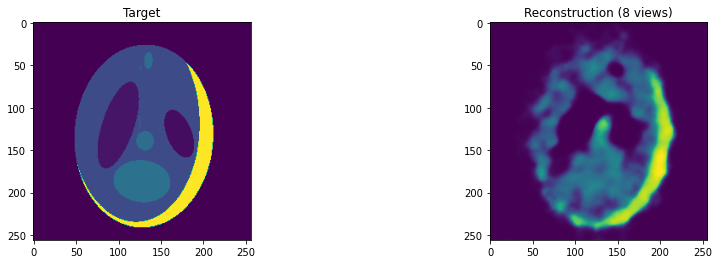

19.01095


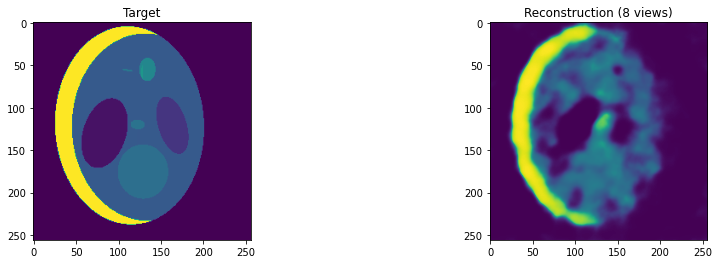

19.000532


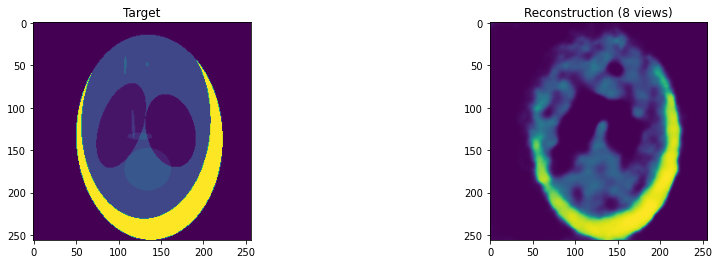

19.003548


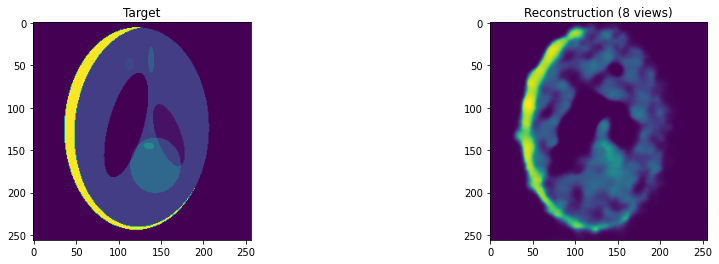

19.009464


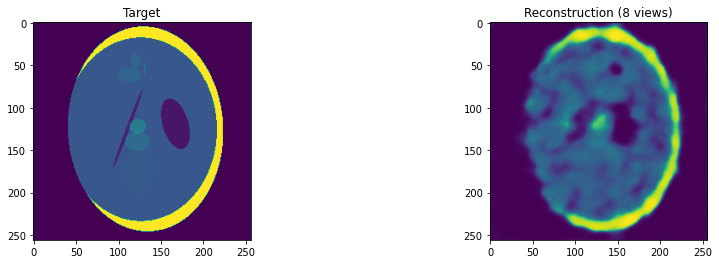

19.005806


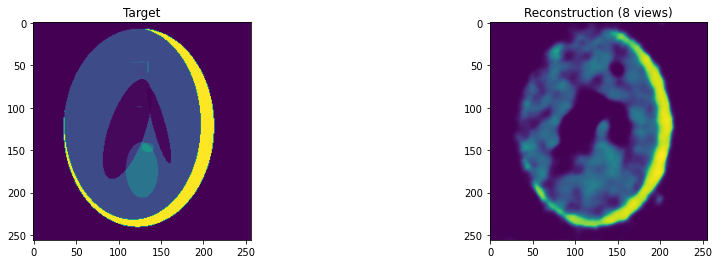

19.001247


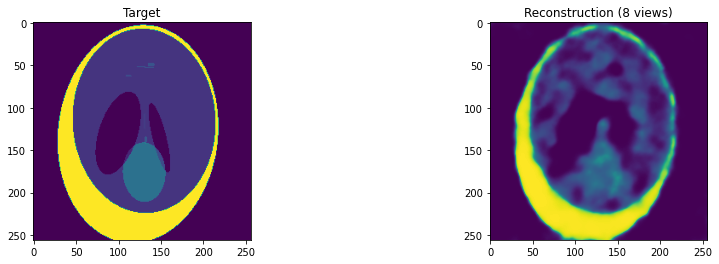

19.005486


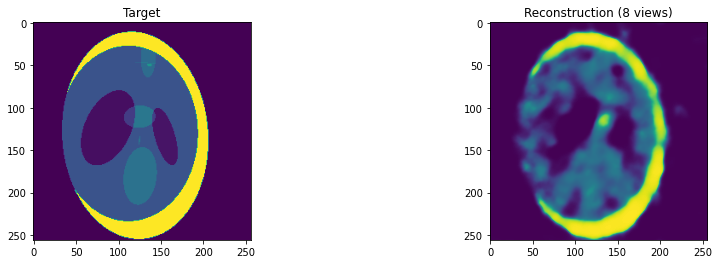

In [ ]:

#meta train
num_views = 8
lr = 10
steps = 1000
adam = False
key = hk.PRNGSequence(42)
model = hk.without_apply_rng(hk.transform(lambda x: Model()(x)))
random_params = model.init(next(key), np.ones((1,2)))
num_examples = 30
startTime = time.time()
metatest30ImagesTime = []

meta30steps = []
metatest30Images = []
starter = 1
for image in dataset['data_test'][:num_examples]:
    metatest30ImagesTimeR,meta30stepsR,train_psnrs, test_psnrs, rec_img, _ = train_model3(image, lr, steps, num_views, adam, params)
    rec_img = (np.clip(rec_img, 0, 1)*255).astype(np.uint8)
    metatest30ImagesTime.append(metatest30ImagesTimeR)
    meta30steps.append(meta30stepsR)
    metatest30Images.append(starter)
    starter+=1

    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Target')
    plt.subplot(1,2,2)
    plt.imshow(rec_img)
    plt.title(f'Reconstruction ({num_views} views)')
    plt.show()
meta_total_time = time.time()-startTime

In [ ]:
print(metatest30Images)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [ ]:
print(meta30steps)

[11, 10, 12, 19, 29, 13, 245, 32, 153, 42, 88, 60, 32, 228, 84, 1, 126, 9, 45, 83, 59, 54, 81, 93, 50, 112, 227, 156, 222, 221]


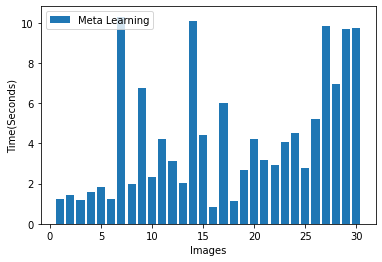

In [ ]:
#a2
plt.bar(metatest30Images,metatest30ImagesTime,label='Meta Learning')
plt.legend()
plt.xlabel('Images')
plt.ylabel('Time(Seconds)')
plt.show()

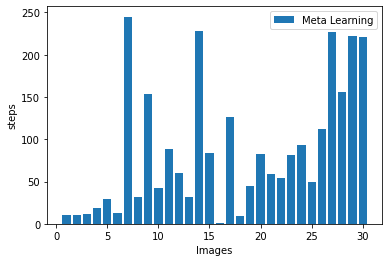

In [ ]:
#b2
plt.bar(metatest30Images,meta30steps,label='Meta Learning')
plt.legend()
plt.xlabel('Images')
plt.ylabel('steps')
plt.show()

In [ ]:
4#100 images reach 20 psnr score(random)
mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))
RES = 256
@partial(jit, static_argnums=[0,5])
def test_model_step4(model, image_proj, coords, thetas, params, opt, opt_state):
    def loss_fn(params):
        g = model.apply(params, coords)
        g_proj = ct_project_batch(g, thetas)
        return mse_fn(g_proj, image_proj), g

    (loss, img), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, img

def train_model4(image, lr, steps, num_views, adam=True, params=None):
    randomtest30ImagesTime = []

    random30steps = []
    randomtest30ImagesStartTime = time.time()
    randomtest30Images = []
    startTime = time.time()

    rng = random.PRNGKey(0)
    x1 = np.linspace(0, 1, RES+1)[:-1]
    coords = np.stack(np.meshgrid(x1,x1), axis=-1)
    
    thetas = np.linspace(0,np.pi, num_views, endpoint=False)
    image_proj = ct_project_batch(image, thetas)

    model = hk.without_apply_rng(hk.transform(lambda x: Model()(x)))
    if params is None:
        params = model.init(rng, coords)
        
    if adam:
        opt = optax.adam(lr)
    else:
        opt = optax.sgd(lr)
    opt_state = opt.init(params)
    
    train_psnrs = []
    test_psnrs = []
    #the below is the test
    random30stepsR = steps
    for i in range(steps):
        params, opt_state, loss, img = test_model_step4(model, image_proj, coords, thetas, params, opt, opt_state)
        train_psnrs.append(-10 * np.log10(loss))
        meta_psnr = psnr_fn(img, image)
        #test_psnrs.append(meta_psnr)
        randomtest30ImagesTimeR=time.time()-randomtest30ImagesStartTime#time
        if meta_psnr>=19:
          randomtest30ImagesTimeR=time.time()-randomtest30ImagesStartTime#time
          #randomtest30Images.append(starter)#images
          random30stepsR=i#steps
          print(meta_psnr)
          break

        

    return randomtest30ImagesTimeR,random30stepsR,train_psnrs, test_psnrs, img, params

19.0121


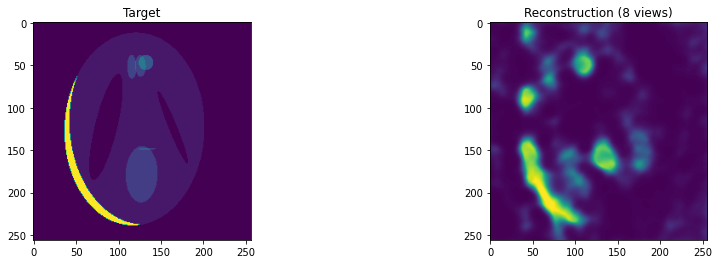

19.111853


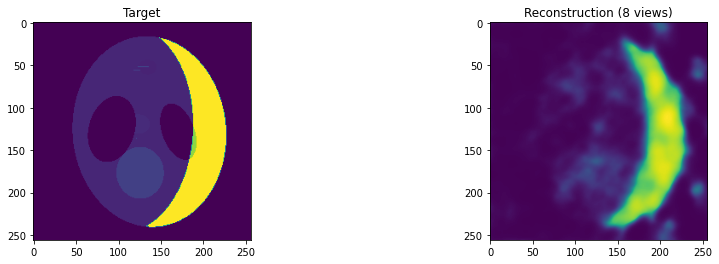

19.015608


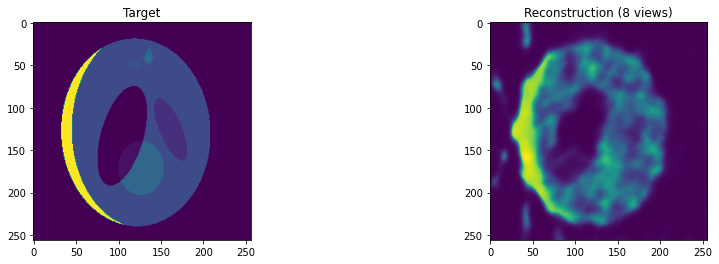

19.024694


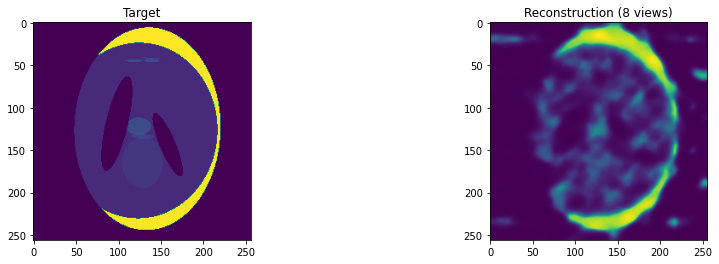

19.019783


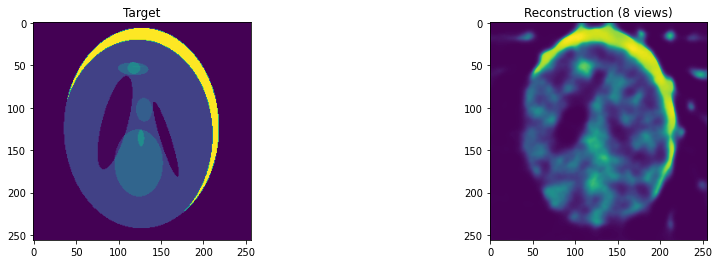

19.088337


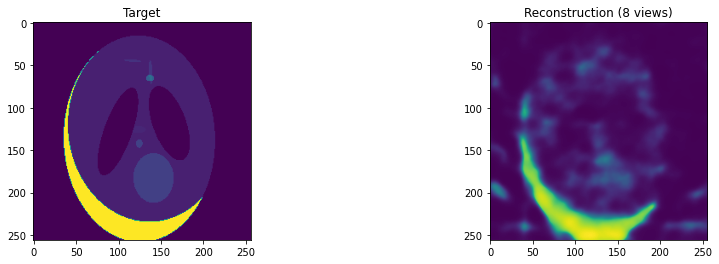

19.010418


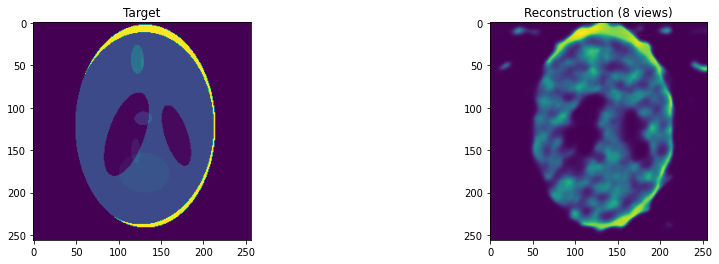

19.017319


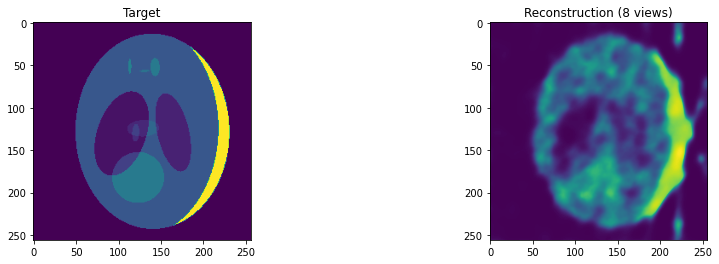

19.002247


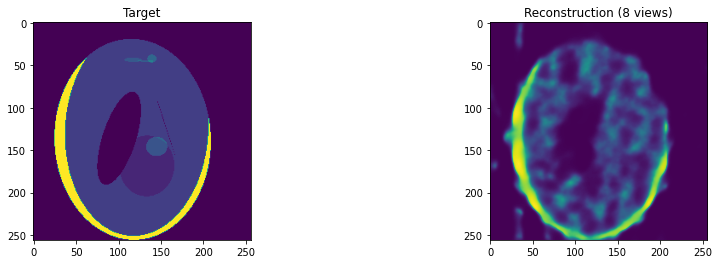

19.037088


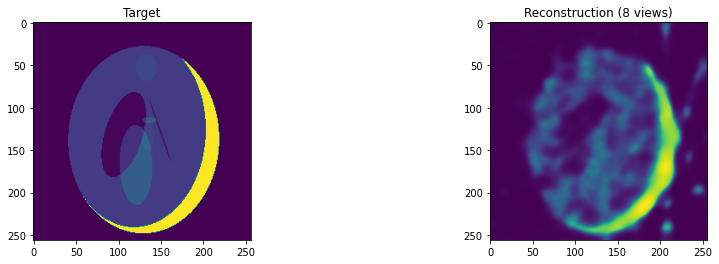

19.007809


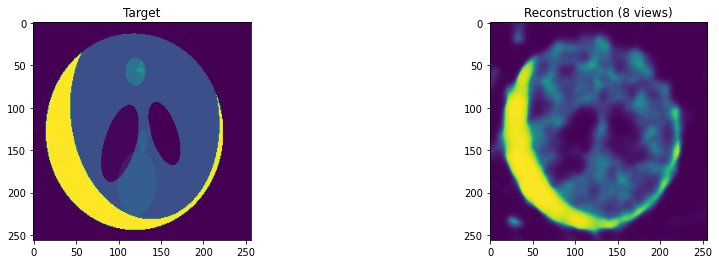

19.043392


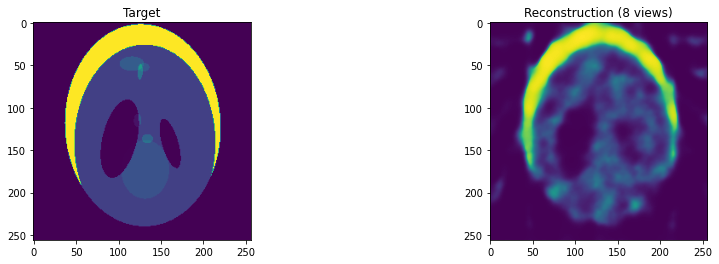

19.014868


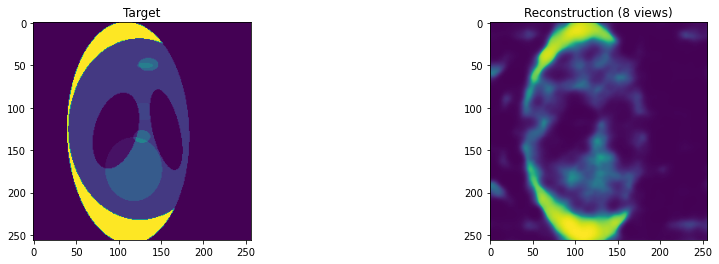

19.003487


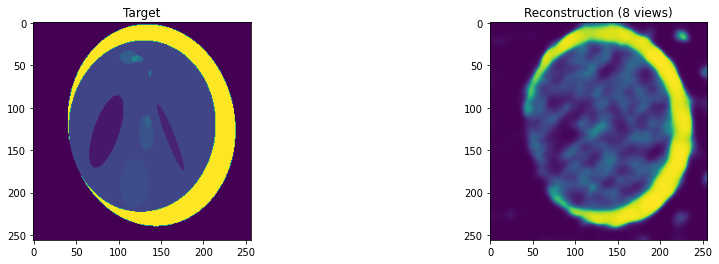

19.053265


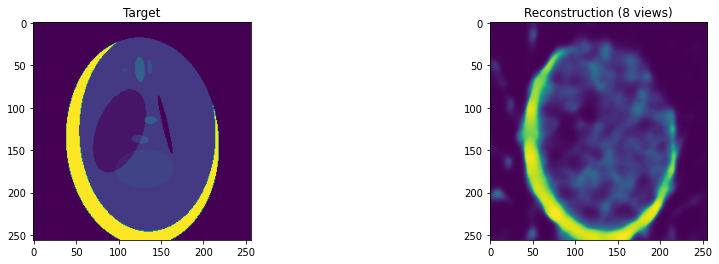

19.598476


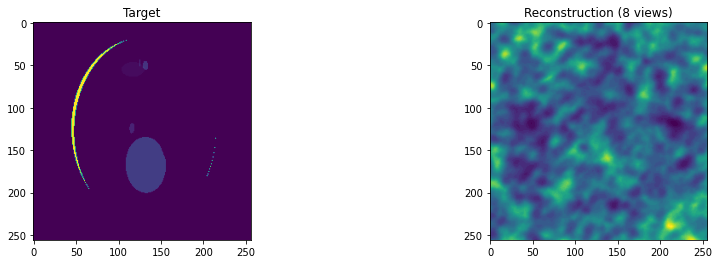

19.011883


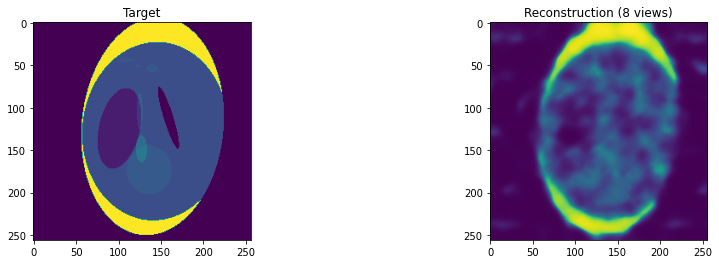

19.003819


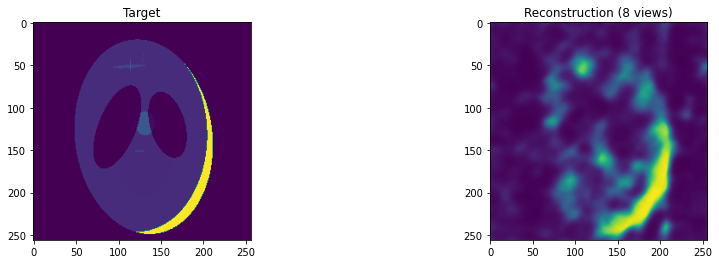

19.042667


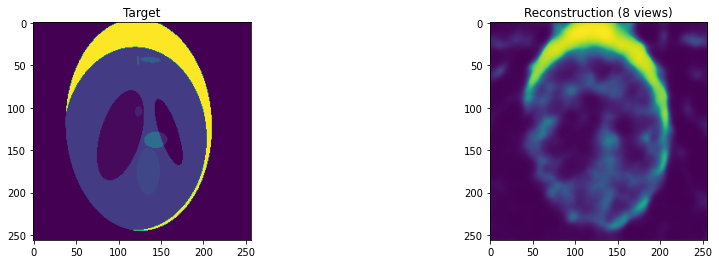

19.011715


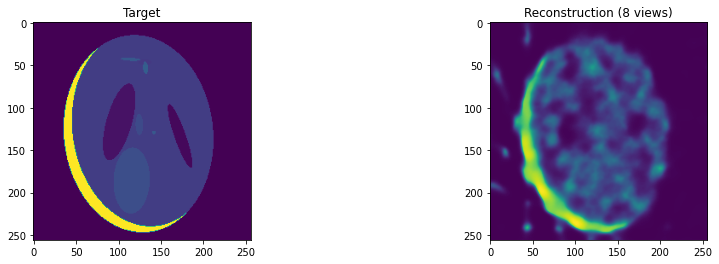

19.054646


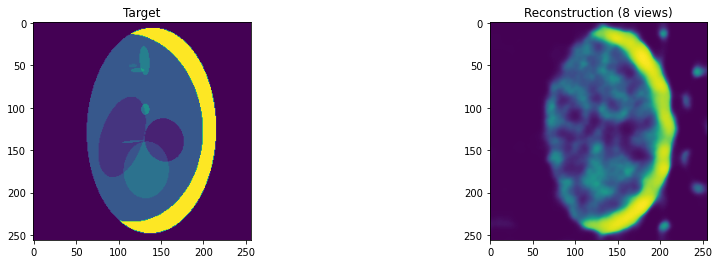

19.029999


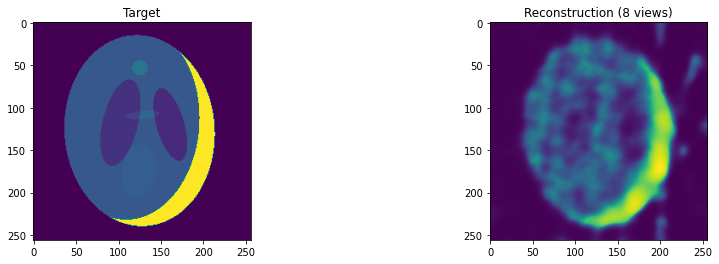

19.028574


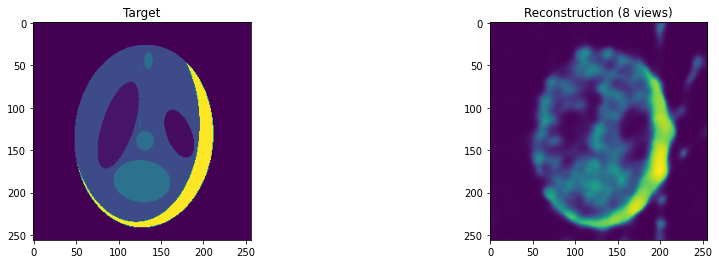

19.02314


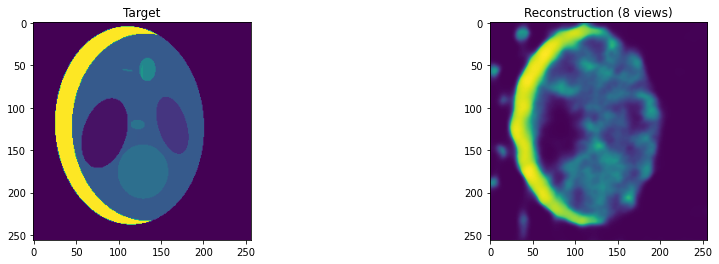

19.008387


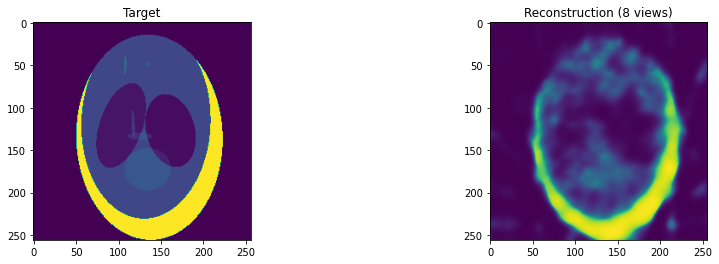

19.025024


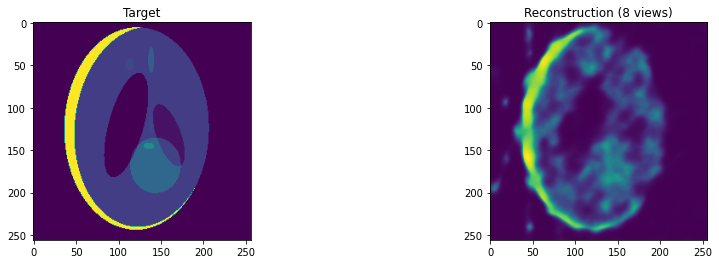

19.010056


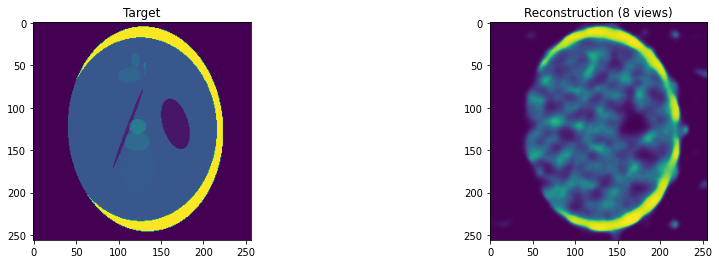

19.007921


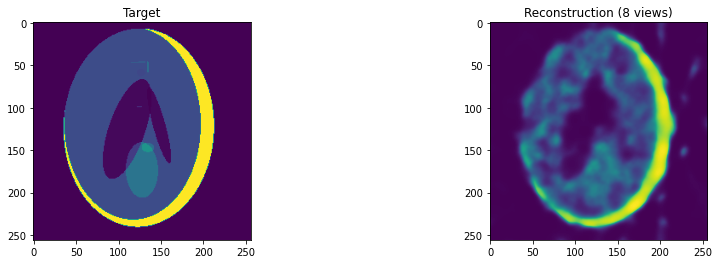

19.006702


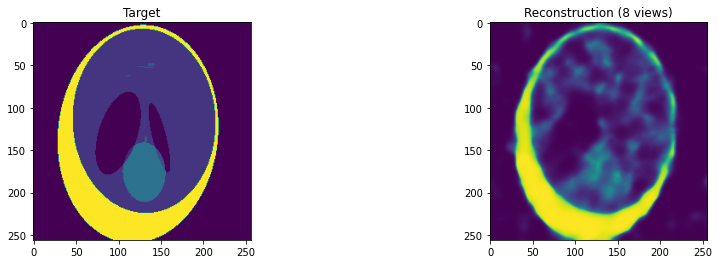

19.013168


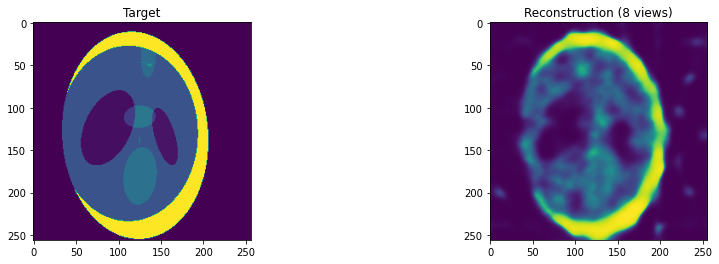

In [ ]:
#random initial
num_views = 8
lr = 5e-4
steps = 1000
adam = True
key = hk.PRNGSequence(42)
model = hk.without_apply_rng(hk.transform(lambda x: Model()(x)))
random_params = model.init(next(key), np.ones((1,2)))
num_examples = 30
randomtest30ImagesTime = []

random30steps = []
randomtest30Images = []
startTime = time.time()
starter = 1
for image in dataset['data_test'][:num_examples]:
    randomtest30ImagesTimeR,random30stepsR,train_psnrs, test_psnrs, rec_img, _ = train_model4(image, lr, steps, num_views, adam, random_params)
    rec_img = (np.clip(rec_img, 0, 1)*255).astype(np.uint8)
    randomtest30ImagesTime.append(randomtest30ImagesTimeR)
    random30steps.append(random30stepsR)
    randomtest30Images.append(starter)
    
    starter+=1
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title('Target')
    plt.subplot(1,2,2)
    plt.imshow(rec_img)
    plt.title(f'Reconstruction ({num_views} views)')
    plt.show()
random_total_time = time.time()-startTime

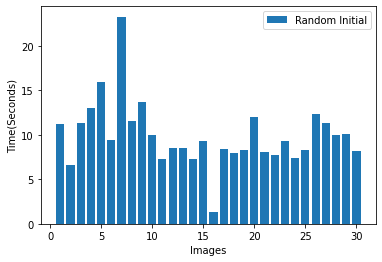

In [ ]:
#c2
plt.bar(randomtest30Images,randomtest30ImagesTime,label='Random Initial')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.xlabel('Images')
plt.ylabel('Time(Seconds)')
plt.show()

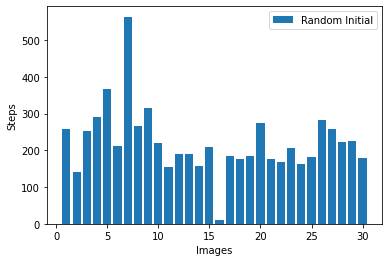

In [ ]:
#d2
plt.bar(randomtest30Images,random30steps,label='Random Initial')
#plt.plot(time_stamps,train_psnrs,label='Train')
plt.legend()
plt.xlabel('Images')
plt.ylabel('Steps')
plt.show()

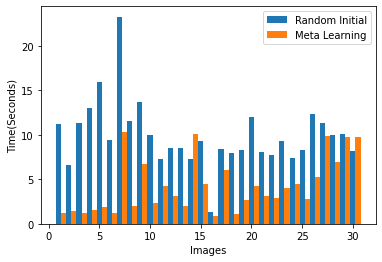

In [ ]:
#e2
x_width = range(1,len(random30steps)+1)
x2_width = [i+0.5 for i in x_width]

plt.bar(x_width,randomtest30ImagesTime,lw=5,width=0.5,label='Random Initial')
plt.bar(x2_width,metatest30ImagesTime,lw=5,width=0.5,label='Meta Learning')
plt.legend()
plt.xlabel('Images')
plt.ylabel('Time(Seconds)')
plt.show()

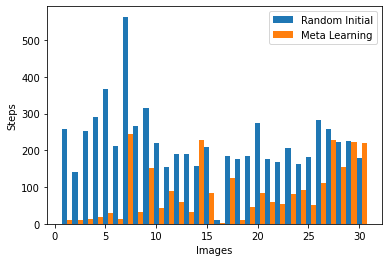

In [ ]:
x_width = range(1,len(random30steps)+1)
x2_width = [i+0.5 for i in x_width]

plt.bar(x_width,random30steps,lw=5,width=0.5,label='Random Initial')
plt.bar(x2_width,meta30steps,lw=5,width=0.5,label='Meta Learning')
#plt.xticks(range(0,30),random30steps)
plt.legend()
plt.xlabel('Images')
plt.ylabel('Steps')
plt.show()

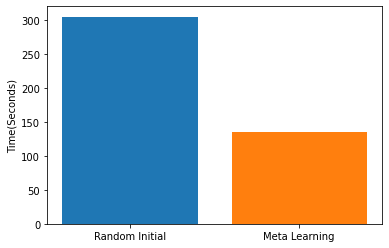

In [ ]:
x_array = ['Random Initial','Meta Learning']
y_array1 = [random_total_time,meta_total_time]
for i in range(len(x_array)):
  plt.bar(x_array[i],y_array1[i])


#plt.plot(time_stamps,train_psnrs,label='Train')
#plt.legend()
#plt.xlabel('Images')
plt.ylabel('Time(Seconds)')
plt.show()

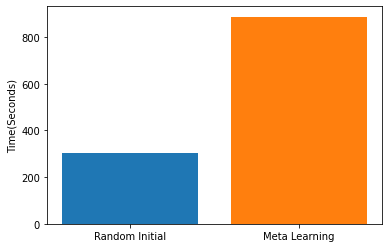

In [ ]:
x_array = ['Random Initial','Meta Learning']
y_array1 = [random_total_time,meta_total_time+time_stamps[-1]]
for i in range(len(x_array)):
  plt.bar(x_array[i],y_array1[i])


#plt.plot(time_stamps,train_psnrs,label='Train')
#plt.legend()
#plt.xlabel('Images')
plt.ylabel('Time(Seconds)')
plt.show()